In [1]:

import pandas as pd 
import torch 
import matplotlib.pyplot as plt
import numpy as np 


ModuleNotFoundError: No module named 'pandas'

#Определим сеть

In [91]:
from torch import nn
class Perceptron1(torch.nn.Module):
    def __init__(self):
        super(Perceptron1, self).__init__()
        self.fc1 = nn.Linear(10, 1000)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(500, 250)
        self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(250, 125)
        self.act4 = nn.Sigmoid()
        self.fc5 = nn.Linear(125, 1)
        self.act5 = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x

class Perceptron2(torch.nn.Module):
    def __init__(self):
        super(Perceptron2, self).__init__()
        self.fc1 = nn.Linear(10, 500)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(1000, 2000)
        self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(2000, 1000)
        self.act4 = nn.Sigmoid()
        self.fc5 = nn.Linear(1000, 800)
        self.act5 = nn.Sigmoid()
        self.fc6 = nn.Linear(800, 200)
        self.act6 = nn.Sigmoid()
        self.fc7 = nn.Linear(200, 1)
        self.act7 = nn.Tanh()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)
        x = self.act7(x)
        return x

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Обучение

In [92]:
import time
def generate_batch_data(device, x, y, batch_size):
    dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    for batch, [x_batch, y_batch] in enumerate(loader, 1):
        yield x_batch, y_batch, batch

Сделаем предобработку

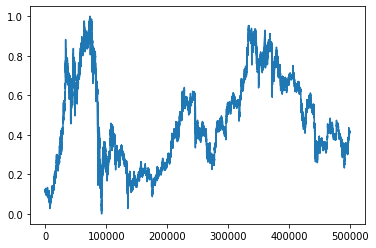

In [93]:
time_series = list(map(float, eval(open('task1.txt', 'r').read())))
series_min = min(time_series)
series_max = max(time_series)
std_time_series = [(item - series_min) / (series_max - series_min) for item in time_series]
def scaled(iterable, min, max):
    ans = [item * (max-min)+ min for item in iterable]
    return ans
plt.plot(range(len(std_time_series)), std_time_series)
plt.show()

x_train  torch.Size([4980, 10])
x_validatation  torch.Size([4980, 10])
y_train  torch.Size([4980])
y_validatation  torch.Size([4980])


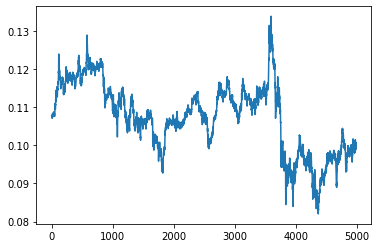

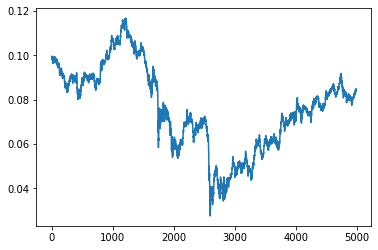

In [106]:

train_ratio = int(0.01 * len(std_time_series))
stop = int(0.02 * len(std_time_series))
train = std_time_series[:train_ratio]
validation = std_time_series[train_ratio:stop]

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def inverse_difference(inverted, first_value):
    original = [first_value]
    for i, item in enumerate(inverted):
        original.append(original[i] + item)
    return original

# inverted_train = difference(train)
# inverted_validation = difference(validation)
inverted_train = (train)
inverted_validation = (validation)


x_train = [inverted_train[i:i+10] for i in range(len(inverted_train) - 10)]
x_validatation = [inverted_validation[i:i+10] for i in range(len(inverted_validation) - 10)]

y_train = inverted_train[10:]
y_validatation = inverted_validation[10:]

x_train = np.array(x_train)
x_train = torch.from_numpy(x_train).float()
print("x_train ", x_train.size())
x_validatation = np.array(x_validatation)
x_validatation = torch.from_numpy(x_validatation).float()
print("x_validatation ", x_validatation.size())
y_train = np.array(y_train)
y_train = torch.from_numpy(y_train).float()
print("y_train ", y_train.size())
y_validatation = np.array(y_validatation)
y_validatation = torch.from_numpy(y_validatation).float()
print("y_validatation ", y_validatation.size())
plt.plot(range(len(inverted_train)),inverted_train)
plt.show()

plt.plot(range(len(inverted_validation)),inverted_validation)
plt.show()




In [108]:
def totrain(model, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer):
    train_losses = []
    validation_losses = []
    model.train()
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = 0
        val_loss = 0
        batch = 0
        for x_batch, y_batch, batch in generate_batch_data(device, x_train, y_train, batch_size):
            if type(model) == LSTM:
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(x_batch)

            optimizer.zero_grad()
            loss = loss_function(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= batch
        train_losses.append(train_loss)

        with torch.no_grad():
            for x_val_batch, y_val_batch, n in generate_batch_data(device, x_validatation, y_validatation, batch_size):
                val_loss += loss_function(model(x_val_batch), y_val_batch).item()
            val_loss /= n
            validation_losses.append(val_loss)
        elapsed = time.time() - start_time
        if True:
            print(f"Epoch {str(epoch + 1):>02}"
                    f" Train loss: {train_loss:.7f}."
                    f" Validation loss: {val_loss:.7f}."
                    f" Elapsed time: {elapsed:.2f}s.")
    return model, train_losses, validation_losses
    


Epoch 01 Train loss: 0.0033215. Validation loss: 0.1429438. Elapsed time: 6.75s.
Epoch 02 Train loss: 0.0011328. Validation loss: 0.1448325. Elapsed time: 6.32s.
Epoch 03 Train loss: 0.0011175. Validation loss: 0.1490216. Elapsed time: 7.07s.
Epoch 04 Train loss: 0.0011632. Validation loss: 0.1530466. Elapsed time: 7.59s.
Epoch 05 Train loss: 0.0011197. Validation loss: 0.1521351. Elapsed time: 6.48s.
Epoch 06 Train loss: 0.0011283. Validation loss: 0.1534385. Elapsed time: 6.51s.
Epoch 07 Train loss: 0.0011119. Validation loss: 0.1539829. Elapsed time: 6.45s.
Epoch 08 Train loss: 0.0011315. Validation loss: 0.1545390. Elapsed time: 6.42s.
Epoch 09 Train loss: 0.0011367. Validation loss: 0.1548684. Elapsed time: 6.55s.
Epoch 10 Train loss: 0.0011485. Validation loss: 0.1545349. Elapsed time: 6.37s.
Epoch 11 Train loss: 0.0011801. Validation loss: 0.1534359. Elapsed time: 6.56s.
Epoch 12 Train loss: 0.0011328. Validation loss: 0.1548374. Elapsed time: 6.39s.
Epoch 13 Train loss: 0.00115

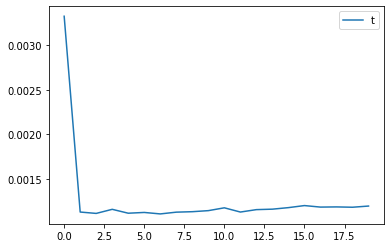

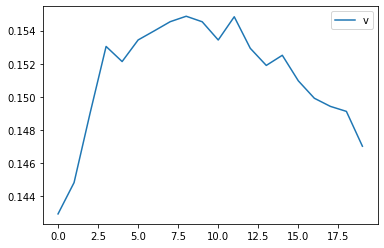

In [96]:
model1 = LSTM(10,100,1)
device = torch.device('cpu')
batch_size= 1
n_epochs= 20
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model1, train_loss1, val_loss1 = totrain(model1, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss1)),train_loss1)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss1)),val_loss1)
plt.legend("val_loss")
plt.show()

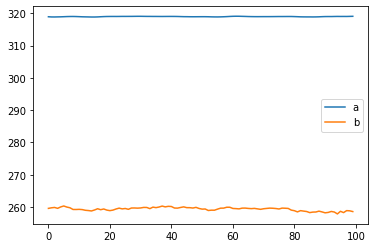

In [97]:
done_model1.eval()
future = 100
a = list(map(lambda x: done_model1(torch.reshape(x, (1, 10))).item(), x_validatation))
# a = inverse_difference(a, validation[0])
a = scaled(a, series_min, series_max)
b = list(map(lambda x: x.item(), y_validatation))
# b = inverse_difference(b, validation[0])
b = scaled(b, series_min, series_max)
plt.plot(range(len(a[:future])),a[:future], label="a")
plt.plot(range(len(b[:future])), b[:future], label="b")
plt.legend()
plt.show()

/Users/petrlarockin/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/petrlarockin/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 01 Train loss: 0.1563270. Validation loss: 0.1786547. Elapsed time: 2.84s.
Epoch 02 Train loss: 0.0752437. Validation loss: 0.0583005. Elapsed time: 2.65s.
Epoch 03 Train loss: 0.0596926. Validation loss: 0.0695361. Elapsed time: 2.68s.
Epoch 04 Train loss: 0.0200688. Validation loss: 0.0187381. Elapsed time: 2.89s.
Epoch 05 Train loss: 0.0156139. Validation loss: 0.0141842. Elapsed time: 2.74s.
Epoch 06 Train loss: 0.0257104. Validation loss: 0.0463724. Elapsed time: 2.79s.
Epoch 07 Train loss: 0.0125904. Validation loss: 0.0359176. Elapsed time: 2.77s.
Epoch 08 Train loss: 0.0070844. Validation loss: 0.0171521. Elapsed time: 2.73s.
Epoch 09 Train loss: 0.0179556. Validation loss: 0.0242548. Elapsed time: 2.77s.
Epoch 10 Train loss: 0.0158854. Validation loss: 0.0282347. Elapsed time: 2.65s.
Epoch 11 Train loss: 0.0087248. Validation loss: 0.0145039. Elapsed time: 2.66s.
Epoch 12 Train loss: 0.0291373. Validation loss: 0.0602925. Elapsed time: 2.71s.
Epoch 13 Train loss: 0.01801

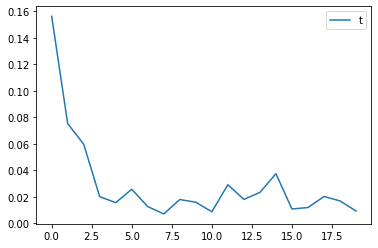

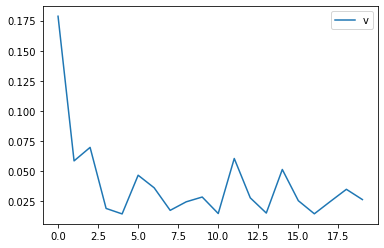

In [98]:
model2 = Perceptron2()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model2, train_loss2, val_loss2 = totrain(model2, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss2)),train_loss2)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss2)),val_loss2)
plt.legend("val_loss")
plt.show()


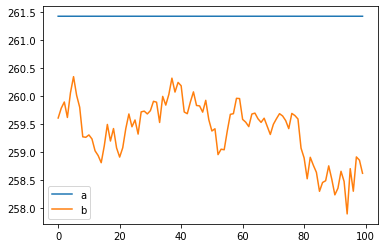

In [99]:
done_model2.eval()
future = 100
a = list(map(lambda x: done_model2(torch.reshape(x, (1, 10))).item(), x_validatation))

a = scaled(a, series_min, series_max)
b = list(map(lambda x: x.item(), y_validatation))
b = scaled(b, series_min, series_max)
plt.plot(range(len(a[:future])),a[:future], label="a")
plt.plot(range(len(b[:future])), b[:future], label="b")
plt.legend()
plt.show()

Epoch 01 Train loss: 0.3915949. Validation loss: 0.3920429. Elapsed time: 0.43s.
Epoch 02 Train loss: 0.3402438. Validation loss: 0.3410033. Elapsed time: 0.42s.
Epoch 03 Train loss: 0.2895948. Validation loss: 0.2910494. Elapsed time: 0.51s.
Epoch 04 Train loss: 0.2404106. Validation loss: 0.2431422. Elapsed time: 0.42s.
Epoch 05 Train loss: 0.1937878. Validation loss: 0.1985275. Elapsed time: 0.43s.
Epoch 06 Train loss: 0.1510119. Validation loss: 0.1584749. Elapsed time: 0.42s.
Epoch 07 Train loss: 0.1132351. Validation loss: 0.1239016. Elapsed time: 0.42s.
Epoch 08 Train loss: 0.0811205. Validation loss: 0.0950950. Elapsed time: 0.42s.
Epoch 09 Train loss: 0.0546760. Validation loss: 0.0717119. Elapsed time: 0.42s.
Epoch 10 Train loss: 0.0333623. Validation loss: 0.0530053. Elapsed time: 0.42s.
Epoch 11 Train loss: 0.0165479. Validation loss: 0.0382057. Elapsed time: 0.42s.
Epoch 12 Train loss: 0.0069662. Validation loss: 0.0294293. Elapsed time: 0.52s.
Epoch 13 Train loss: 0.00741

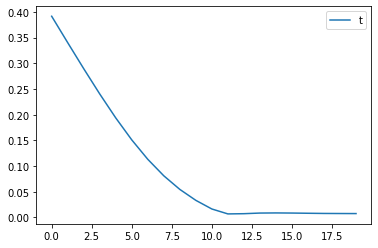

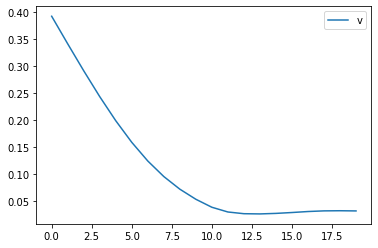

In [100]:
model3 = Perceptron1()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model3, train_loss3, val_loss3 = totrain(model3, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss3)),train_loss3)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss3)),val_loss3)
plt.legend("val_loss")
plt.show()

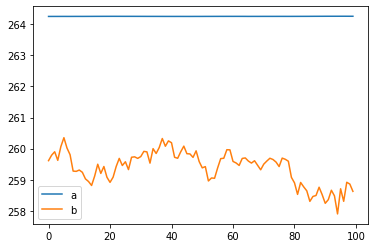

In [101]:
done_model3.eval()
future = 100
a = list(map(lambda x: done_model3(torch.reshape(x, (1, 10))).item(), x_validatation))

a = scaled(a, series_min, series_max)
b = list(map(lambda x: x.item(), y_validatation))
b = scaled(b, series_min, series_max)
plt.plot(range(len(a[:future])),a[:future], label="a")
plt.plot(range(len(b[:future])), b[:future], label="b")
plt.legend()
plt.show()

Система принятия решения

In [129]:
from torch import nn
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 500)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(1000, 500)
        self.act3 = nn.Tanh()
        self.fc4 = nn.Linear(500, 250)
        self.act4 = nn.Tanh()
        self.fc5 = nn.Linear(250, 1)
        self.act5 = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x
classifier = Classifier()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
train_losses = []
validation_losses = []
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
loss_function = torch.nn.BCELoss()


y_train = torch.from_numpy(np.array(difference(train[10:])))
y_train[y_train > 0] = 1
y_train[y_train <= 0] = 0

y_validatation = torch.from_numpy(np.array(difference(validation[10:])))
y_validatation[y_validatation > 0] = 1
y_validatation[y_validatation <= 0] = 0

print(x_train.size())
print(y_train.size())
print(x_validatation.size())
print(y_validatation.size())

classificator, classificator_train, classificator_validation = totrain(classifier, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)

torch.Size([1, 10, 4980])
torch.Size([4979])
torch.Size([4980, 10])
torch.Size([4979])


AssertionError: Size mismatch between tensors

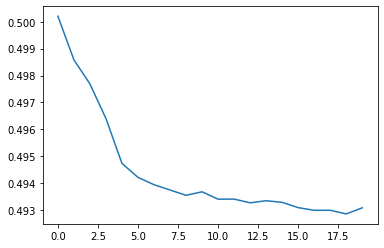

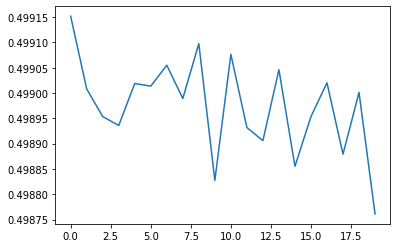

In [69]:
plt.plot(range(len(classificator_train)), classificator_train)
plt.show()
plt.plot(range(len(classificator_validation)), classificator_validation)
plt.show()

In [ ]:
def get_recomendation(classificator, first_ten, thresh):
    first_ten = torch.tensor(first_ten)
    ans = classificator(first_ten)
    return ans >= thresh